# Generating SLiM exome recombination map with admixture array sites

In [1]:
from pybedtools import BedTool
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
RECOMB_RATE = 1e-8 # crossovers per bp per generation

## Exon coordinates processing

First download the GTF annotations:

In [4]:
gtf = pd.read_table('ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/Homo_sapiens.GRCh37.75.gtf.gz',
                    header=None, sep='\t', skipinitialspace=True, skiprows=5, compression='gzip',
                    names=['chrom', 'source', 'feature', 'start', 'end',
                           'score', 'strand', 'frame', 'attribute'], low_memory=False)

How does the data look like?

In [5]:
gtf.head()

,chrom,source,feature,start,end,score,strand,frame,attribute
0,1,pseudogene,gene,11869,14412,.,+,.,"gene_id ""ENSG00000223972""; gene_name ""DDX11L1""..."
1,1,processed_transcript,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
2,1,processed_transcript,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
3,1,processed_transcript,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
4,1,processed_transcript,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."


In [6]:
gtf.source.value_counts()

protein_coding                        2001054
nonsense_mediated_decay                293471
processed_transcript                   173401
retained_intron                        150034
lincRNA                                 55928
antisense                               45811
processed_pseudogene                    24517
pseudogene                              17830
unprocessed_pseudogene                  13763
miRNA                                   10209
transcribed_unprocessed_pseudogene       7931
misc_RNA                                 6554
snRNA                                    6215
snoRNA                                   4791
sense_intronic                           3241
polymorphic_pseudogene                   1906
rRNA                                     1706
unitary_pseudogene                       1467
sense_overlapping                        1463
IG_V_gene                                1277
transcribed_processed_pseudogene         1182
non_stop_decay                    

In [7]:
gtf.feature.value_counts()

exon              1306656
CDS                791856
UTR                304070
transcript         215170
stop_codon          73411
start_codon         73358
gene                63677
Selenocysteine        114
Name: feature, dtype: int64

Take only autosomal protein-coding regions, since we won't be simulating sex chromosomes:

In [8]:
AUTOSOMES = [str(i + 1) for i in range(22)]

In [9]:
exons = gtf[gtf.chrom.isin(AUTOSOMES) &
           (gtf.source == "protein_coding") &
           (gtf.feature == "exon")]

Merge the overlapping exons:

In [10]:
exons = BedTool.from_dataframe(exons).sort().merge().to_dataframe()

In [11]:
exons['name'] = 'exon'

Convert chromosome IDs to integers and sort exons by chromosome:

In [12]:
exons.chrom = exons.chrom.astype(int)
exons.sort_values(by=['chrom', 'start'], inplace=True)

What is the distribution of exon lengths?

In [13]:
((exons.end - exons.start)).describe()

count    214193.000000
mean        337.708039
std         776.506070
min           1.000000
25%          96.000000
50%         138.000000
75%         217.000000
max       24409.000000
dtype: float64

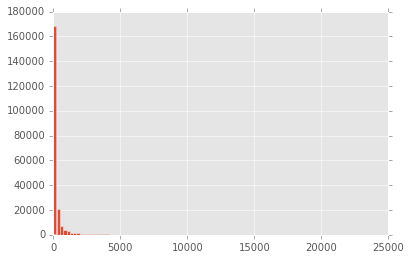

In [14]:
plt.figure_ = plt.hist((exons.end - exons.start), bins=100)

Filter out some riduculously small exons:

In [15]:
exons = exons[(exons.end - exons.start) > 10]

## Process positions from the archaic admixture array

Load the coordinates of sites from the archaic admixture array:

In [16]:
array_sites = pd.read_table('../raw_data/ice_age/filter.gz', names=['chrom', 'end', 'set_1', 'set_2'])

Subset to sites in the so called "Set 1" (see `raw_data/ice_age/README.md` for more information):

In [17]:
array_sites = array_sites[array_sites.set_1 == 1]

Find sites that don't fall withing exonic regions. These will be simulated individually when building the recombination map. The ones within the exons will be recombining simply as part of the exons:

In [18]:
array_sites['start'] = array_sites.end - 1

In [19]:
array_sites = array_sites[['chrom', 'start', 'end']]

In [20]:
array_sites['name'] = 'snp'

## Create a union of exon regions with admixture array informative positions

Informative sites within exons will be simulated simply as part of the exons. Inter-exon informative sites will be simulated individually, with an appropriate recombination rate set between them and both adjacent exons or other informative sites.

In [21]:
exome = BedTool.from_dataframe(exons)

# take subset of array sites that lie outside exons
array = BedTool.from_dataframe(array_sites).intersect(exome, v=True)

In [22]:
exons_and_sites = pd.concat([exome.to_dataframe(),
                             array.to_dataframe()]).sort_values(by=['chrom', 'start']).reset_index(drop=True)

## Generating the recombination map

Recombination rate between exons is implemented by inserting a 1 bp "gap" between each pair of adjacent exons and setting the recombination rate at these positions to $L \times 1\cdot10^{-8}$ crossovers per generation ($L$ is the distance between adjacent exons).

The recombination rate of the "gap" between the last exon on one chromosome and the first exon on another chromosome will be 0.5.

Specify the recombination rate for exons ($10^{-8}$):

In [23]:
exons_and_sites.ix[exons_and_sites.name == 'exon', 'recomb_rate'] = RECOMB_RATE

In [24]:
def add_recombination_gaps(regions):
    """Add 1 bp "recombination gaps" between each region/site in the given
    DataFrame.
    """
    # create a new DataFrame with coordinates of 1 bp inter-exonic gaps
    gaps = pd.DataFrame({'chrom'       : regions.chrom.values,
                         'start'       : regions.end.values,
                         'end'         : regions.end.values + 1,
                         'recomb_rate' : list(RECOMB_RATE * (regions.start[1:].values - regions.end[:-1].values)) + [0.5],
                         'name'        : 'gap'},
                        columns=['chrom', 'start', 'end', 'recomb_rate', 'name'])
    
    # merge the dataframes of exon and gap coordinates
    regions_and_gaps = pd.concat([regions, gaps]).sort_values(by=['chrom', 'start']).reset_index(drop=True)
    
    # calculate the end position of each simulated region and gap
    # (this is how a recombination map is specified for SLiM)
    regions_and_gaps['interval_end'] = (regions_and_gaps.end - regions_and_gaps.start).cumsum()
    
    # return recombination map between exons and admixture array sites
    # (snp records can be ignored, since they were used only to place
    # 1 bp "gaps" inbetween)
    return regions_and_gaps.query('name != "snp"')[['chrom', 'start', 'end', 'name', 'interval_end', 'recomb_rate']]


def create_genome_recomb_map(regions):
    """Create recombination map for all chromosomes.
    
    SLiM simulates the whole genome as one segment. Therefore, all
    exons on all chromosomes have to be concatenated and all coordinates
    have to be shifted appropriately (i.e. first coordinate on the chromosome 2
    has to be incremented by a last coordinate of the chromosome 1).
    """
    recomb_map = {}
    previous_end = 0

    for chrom in AUTOSOMES:
        # add recombination gaps between regions on this chromosome
        recomb_map[chrom] = add_recombination_gaps(regions.query('chrom == {}'.format(chrom)))

        # increment the positions of the recombination map based on the
        # last position on the previous chromosome
        recomb_map[chrom].interval_end += previous_end

        # get the currently last position of the
        previous_end = max(recomb_map[chrom].interval_end)
        
    # concatenate exome recombination maps of all chromosomes
    recomb_map = pd.concat(recomb_map, ignore_index=True).sort_values(by='interval_end')
    
    # convert interval end coordinates to 0-based indexing as required by SLiM
    recomb_map.interval_end -= 1

    # remove the very last base of the recombination map
    # (it has a 0.5 recombination rate anyway and there's no other chromosome
    # after it)
    recomb_map = recomb_map[:-1]
    
    return recomb_map

In [25]:
recomb_map = create_genome_recomb_map(exons_and_sites)

### The final recombination map to use in SLiM

In [26]:
recomb_map.head(25)

,chrom,start,end,name,interval_end,recomb_rate
0,1,69090,70008,exon,917,1.000000e-08
1,1,70008,70009,gap,918,6.489200e-04
2,1,134900,135802,exon,1820,1.000000e-08
3,1,135802,135803,gap,1821,1.818000e-05
4,1,137620,139379,exon,3580,1.000000e-08
5,1,139379,139380,gap,3581,2.282600e-03
6,1,367639,368634,exon,4576,1.000000e-08
7,1,368634,368635,gap,4577,2.524240e-03
8,1,621058,622053,exon,5572,1.000000e-08
9,1,622053,622054,gap,5573,1.164780e-03


In [27]:
recomb_map.tail(25)

,chrom,start,end,name,interval_end,recomb_rate
711983,22,51182488,51182634,exon,74070161,1.000000e-08
711984,22,51182634,51182635,gap,74070162,4.460000e-06
711985,22,51183080,51183762,exon,74070844,1.000000e-08
711986,22,51183762,51183763,gap,74070845,2.216600e-04
711987,22,51205928,51207302,exon,74072219,1.000000e-08
711988,22,51207302,51207303,gap,74072220,1.660000e-06
711989,22,51207468,51207552,exon,74072304,1.000000e-08
711990,22,51207552,51207553,gap,74072305,3.000000e-06
711991,22,51207852,51207980,exon,74072433,1.000000e-08
711992,22,51207980,51207981,gap,74072434,3.520000e-06


## Output the result in a format suitable for import into SLiM

In [28]:
!mkdir -p ../clean_data

In [29]:
recomb_map[['interval_end', 'recomb_rate']].to_csv('../clean_data/recomb_map_exome_with_array_sites.txt', sep='\t', index=False, header=False)